In [23]:
##################----------------- Import Libraries -------------########################

from pyomo.environ import *
from pyomo.opt import SolverFactory
import math
import os
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.pf as pf
from pandapower import networks
import pandapower.plotting as plot
import pandapower.networks as pn
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.stats import t
import sys
current_directory = os.getcwd()

In [24]:
# For auto reload libraries without the need to restart kernel
############# USE ONLY IN DEVELOPING MODE FOR EASIER MODIFICAITON IN LIBRARIES ##############
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### This is the BFM

In [25]:
net = pn.simple_four_bus_system()
net.bus['max_vm_pu'] = 1.05
net.bus['min_vm_pu'] = 0.95

In [26]:
############## Initialize model ######################

sys.path.append('../ADN_OPF/src')

from Manager import *
manager = Manager(net=net)
manager.addTime(timeframe=48,time_interval=30) ## At objective, timeframe(in hours) , time-interval(in minutes)
manager.anc_Vars.System_Data_DER.loc[0,'Controllable']=True


In [27]:
#######################------------------- Easy method to get the admittance Matrix ----------------####################33
# Run a power flow calculation

pp.runpp(net)

# Access the Y-bus matrix from the network results
Ybus = net["_ppc"]["internal"]["Ybus"]
# print("Y-bus matrix:\n", Ybus.todense())

# Convert the sparse Y-bus matrix to a dense format and then to a DataFrame
Y_bus_df = pd.DataFrame(Ybus.todense())

# Add row and column labels if needed
Y_bus_df.index = net.bus.index
Y_bus_df.columns = net.bus.index
# print(Y_bus_df)
################### OR ######################

Ybus = build_ybus(net)

### Generate load/DER time scale data
file_path2 = '../Data/profiles/pv_load_profiles/Profiles_for_testing.xlsx'
profiles = pd.read_excel(file_path2)
profiles = pd.concat([profiles]*2, ignore_index=True)

### Generate enviromen data
file_path2 = '../Data/profiles/Enviroment_profiles/dataset2.xlsx'
enviroment_data = pd.read_excel(file_path2, index_col='Time')
enviroment_data=enviroment_data.iloc[0:96,:]

print(Y_bus_df)
print(profiles.head())
print(enviroment_data.head())

                    0                   1                   2  \
0  1.875150-5.962120j -1.357392-6.100772j  0.000000+0.000000j   
1  4.604728-4.225922j  2.365398-6.025498j -0.490248+0.063381j   
2  0.000000+0.000000j -0.490248+0.063381j  0.980497-0.126757j   
3  0.000000+0.000000j  0.000000+0.000000j -0.490248+0.063381j   

                    3  
0  0.000000+0.000000j  
1  0.000000+0.000000j  
2 -0.490248+0.063381j  
3  0.490248-0.063378j  
       Time  PV_Systems  PV_Rooftop  Load_Profile
0  00:00:00    0.000015    0.000015      0.122509
1  00:30:00    0.000015    0.000015      0.118885
2  01:00:00    0.000015    0.000015      0.116586
3  01:30:00    0.000016    0.000016      0.114244
4  02:00:00    0.000016    0.000016      0.111212
                      Tout  SolGlob
Time                               
2019-02-21T18:30:00Z   0.1        0
2019-02-21T19:00:00Z   0.2        0
2019-02-21T19:30:00Z   0.3        0
2019-02-21T20:00:00Z   0.3        0
2019-02-21T20:30:00Z   0.3        0


In [28]:
# Custom Add EVs since in pandapower EVs are not available

manager.anc_Vars.addEV(node=2,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=17,arrival=[31,31+48],departure=[13,13+48],distance=[1,1])
manager.anc_Vars.addEV(node=3,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[3,3+48],distance=[20,20])
manager.anc_Vars.addFlexBuilding(node=2, P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf")
manager.anc_Vars.addFlexBuilding(node=3, P_min=0, P_max=11, RC_Parameters={'R_in_e': 0.004551124290552294, 'R_e_a': 0.027012365446126684, 'R_in_a': 0.028845748703856717, 'C_in': 7735217.032318024, 'C_e': 16672493.772613183, 'Ain': 1.584588253571343, 'Ae': 0.6158433223018948, 'fh': 0.41918973177147334}, Initialization = {'T_in': 21, 'T_e': 21.2}, model_Type="3R2C", time_interval=manager.time_interval, timeframe=manager.timeframe, Q_control="constant_pf")

# print(manager.anc_Vars.system_data_ev)
# print(manager.anc_Vars.system_data_ev_char)
# print(manager.anc_Vars.system_data_hp)

In [29]:
# This code initialize/create all the needed sets in pyomo model.
manager.initialize_sets()  # Initialize sets

print(manager.list_sets())
# manager.show_set("Sbuses")
# manager.show_set("SGenbuses")
# manager.show_set("SGrid")
# manager.show_set("SDER_contr")
# manager.show_set("SDER_uncontr")
# manager.show_set("SLoadbuses")
# manager.show_set("Slines")
# manager.show_set("STimes")
# manager.show_set("SEVbuses")
# manager.show_set("SDistance_ind")
# manager.show_set("SHPbuses")

['Sbuses', 'SGrid', 'SDER_contr', 'SDER_uncontr', 'SLoadbuses', 'Slines', 'STransformers', 'STimes', 'SEVbuses', 'SDistance_ind', 'SHPbuses', 'Sdownstream', 'Supstream', 'Sdownstream_transformer', 'Supstream_transformer', 'Sreverse_lines', 'Sreverse_transformers']


In [30]:
############################---------------------- Define Parameters ---------------------############################

# Why defined parameters? if we defined parameters instead of using for example panda dataframe then we can rerun the model without the need to 
# rebuild the constraints during the solving it automatically get the new parameters so the steps for a load modification example is the following
# 1) Define the load profile dataframe, 2) Run variables 3) Run parameters, 4)Build model, 5) Solve optimization, 6)Change load profile , 7) Run parameters ,8) Solve optimization
# MUTABLE=TRUE is the function parameter that allow this

manager.load_profile_param(profiles=profiles, load_p_name_prefix="Load_P", load_q_name_prefix="Load_Q") # This create Load_P and Load_Q profile which is equal to PandapowerPower*p.u. [from profiles files]
manager.line_param(Y_bus_df=Y_bus_df, resist_prefix="resistance_Parm", react_prefix="reactance_Parm", adm_real_prefix="admitt_mat_Parm_real", adm_img_prefix="admitt_mat_Parm_imag")
manager.transformer_param("transformer_resistance_Parm", "transformer_reactance_Parm") # This create resistance and reactance parameters for transformers

############ EV #################
manager.initialize_ev_params("ev_min_ch_param", "ev_max_ch_param", "EVinit_SOC", "EVend_SOC_param", "EV_SoC_min_param", "EV_SoC_max_param", "EV_capacity_param")
manager.initialize_ev_char_params("ev_arrival_time_param", "ev_departure_time_param", "ev_trip_distance_param", "EV_SoC_min_departure_param",  "EV_trip_energy_needs_param", "EV_available_param" )
manager.initialize_ev_min_soc_timeseries("EV_SoC_min_overtime_param")

############ DER #################
manager.der_profile_param(profiles, "unctrl_PV_gen_P", "unctrl_PV_gen_Q", "ctrl_PV_gen_P", "ctrl_PV_gen_Q")

############ HP #################
manager.initialize_hp_params("min_HP_power", "max_HP_power", "min_temp_preference_param", "max_temp_preference_param")
manager.enviroment_profile_param(enviroment_data, "Tout_param", "Qsolar_param")

print(manager.list_parameters())
manager.show_parameter("Load_P")

['Load_P', 'Load_Q', 'resistance_Parm', 'reactance_Parm', 'admitt_mat_Parm_real', 'admitt_mat_Parm_imag', 'transformer_resistance_Parm', 'transformer_reactance_Parm', 'ev_min_ch_param', 'ev_max_ch_param', 'EVinit_SOC', 'EVend_SOC_param', 'EV_SoC_min_param', 'EV_SoC_max_param', 'EV_capacity_param', 'ev_arrival_time_param', 'ev_departure_time_param', 'ev_trip_distance_param', 'EV_SoC_min_departure_param', 'EV_trip_energy_needs_param', 'EV_available_param', 'EV_SoC_min_overtime_param', 'unctrl_PV_gen_P', 'ctrl_PV_gen_P', 'unctrl_PV_gen_Q', 'ctrl_PV_gen_Q', 'min_HP_power', 'max_HP_power', 'min_temp_preference_param', 'max_temp_preference_param', 'Tout_param', 'Qsolar_param']
Variable Load_P:
  (2, 0): 0.0036752644392
  (2, 1): 0.00356655123
  (2, 2): 0.0034975863051
  (2, 3): 0.0034273171508999996
  (2, 4): 0.003336370929
  (2, 5): 0.0031993126830000005
  (2, 6): 0.0030531054132
  (2, 7): 0.0029361103880999996
  (2, 8): 0.0027957841179
  (2, 9): 0.0026178374244
  (2, 10): 0.002606093392199

In [31]:
############################---------------------- Define Variables ---------------------############################

# ###################### Normal Operation Scenario ########################
manager.initialize_voltage_square_variables(voltage_name_prefix="v")
manager.add_variable(variable_name_prefix="pgrid", variable_set=manager.model.SGrid)
manager.add_variable(variable_name_prefix="qgrid", variable_set=manager.model.SGrid)
manager.add_variable(variable_name_prefix="pline", variable_set=manager.model.Slines)
manager.add_variable(variable_name_prefix="qline", variable_set=manager.model.Slines)
manager.add_variable(variable_name_prefix="ptransformer", variable_set=manager.model.STransformers)
manager.add_variable(variable_name_prefix="qtransformer", variable_set=manager.model.STransformers)
manager.add_variable(variable_name_prefix="transformer_curr", variable_set=manager.model.STransformers)
manager.initialize_der_variables(power_control_name_prefix="pder_contr", power_curtail_prefix="pder_curtail_contr", reactive_prefix_name="qder_contr")
manager.initialize_line_square_variables(line_set=manager.model.Slines, line_curr_name_prefix="Line_curr")
manager.initialize_line_variables(line_set=manager.model.Slines,line_losses_name_prefix = "Line_losses")

ref_bus=0 # THIS MUST BE ADDED AUTOMATICALLY 
for t in manager.model.STimes:
    manager.model.v[ref_bus, t].fix(1)

###################### EV Variables ########################
manager.initialize_ev_variables(pch_name_prefix="pEVch",q_name_prefix="qEV", soc_name_prefix="EVsoc")

###################### HP and Building Variables ########################

manager.initialize_hp_variables(p_name_prefix="p_hp", q_name_prefix="q_hp")
manager.initialize_building_variables(model_type="3R2C", Qhp_name_prefix="Q_thermal", Tin_name_prefix="T_in", Te_name_prefix="T_e", min_temp_preference_param=manager.model.min_temp_preference_param , max_temp_preference_param=manager.model.max_temp_preference_param)

print(manager.list_variables())

['v', 'pgrid', 'qgrid', 'pline', 'qline', 'ptransformer', 'qtransformer', 'transformer_curr', 'pder_contr', 'pder_curtail_contr', 'qder_contr', 'Line_curr', 'Line_losses', 'pEVch', 'qEV', 'EVsoc', 'p_hp', 'q_hp', 'Q_thermal', 'T_in', 'T_e']


In [32]:
####################-------------------- Line Flow constraints -----------------------#######################

manager.add_line_flow_amplitude_losses_constraint(line_set=manager.model.Slines, current_var=manager.model.Line_curr, losses_var=manager.model.Line_losses, line_flow_losses_con_name_prefix="line_losses")

###################-----------------Curtail DER Power Constrain ------------#######################

def Curtail_DER_Power_rule(model, i, time):
    return (model.pder_curtail_contr[i,time] ==  model.pder_curtail_contr[i,  time].ub - model.pder_contr[i,  time])
manager.model.Curtail_DER_cons = Constraint(manager.model.SDER_contr,manager.model.STimes, rule=Curtail_DER_Power_rule)  # Minimum, Maximum power for Gen

####################-------------------- EV Constrain -----------------------#######################

manager.add_ev_soc_constraint("EV_SOC_cons")
# Fix variables for non-charging times
manager.fix_ev_non_charging_times(model_ev_ch=manager.model.pEVch, model_ev_flex_up=None, model_ev_flex_down=None)

####################-------------------- HP Constrain -----------------------#######################
manager.add_building_thermodynamic_constraint(Tin = manager.model.T_in, Te=manager.model.T_e, Qhp=manager.model.Q_thermal, Tout=manager.model.Tout_param,  
                                              Qsol= manager.model.Qsolar_param, Q_dynamic_prefix_name="Q_hp_dynamic_constraint", Te_dynamic_prefix_name="T_e_dynamic_constraint")
manager.add_HP_operation_constraint(Tout_param=manager.model.Tout_param, Qhp=manager.model.Q_thermal, php=manager.model.p_hp,qhp=manager.model.q_hp, php_operation_prefix_name="active_power_hp_operation_constraint", qhp_operation_prefix_name="reactive_power_hp_operation_constraint")

In [33]:
###################-------------------- Power Flow Constrain -----------------------#######################

manager.add_active_power_flow_df_wos_constraint(pder_contrl_var=manager.model.pder_contr, pline_var=manager.model.pline, p_transformer_var=manager.model.ptransformer, pgrid_var=manager.model.pgrid, ev_ch_p_var=manager.model.pEVch, line_current_var=manager.model.Line_curr, transformer_current_var=manager.model.transformer_curr, name_prefix="active_power_flow", p_hp_var=manager.model.p_hp)
manager.add_reactive_power_flow_df_wos_constraint(qder_contr_var=manager.model.qder_contr, qline_var=manager.model.qline, q_transformer_var=manager.model.qtransformer, qgrid_var=manager.model.qgrid, ev_ch_q_var=manager.model.qEV, line_current_var=manager.model.Line_curr, transformer_current_var=manager.model.transformer_curr, name_prefix="reactive_power_flow", q_hp_var=manager.model.q_hp)
manager.add_voltage_power_flow_df_wos_constraint(manager.model.pline, manager.model.qline, manager.model.Line_curr, manager.model.v, manager.model.resistance_Parm , manager.model.reactance_Parm, manager.model.Slines, "voltage_lines_pf" )
manager.add_brunch_current_flow_df_wos_SOCP_constraint(manager.model.pline, manager.model.qline, manager.model.Line_curr, manager.model.v, manager.model.Slines, "current_lines_equal_pf" )
manager.add_voltage_power_flow_df_wos_constraint(manager.model.ptransformer, manager.model.qtransformer, manager.model.transformer_curr, manager.model.v, manager.model.transformer_resistance_Parm, manager.model.transformer_reactance_Parm, manager.model.STransformers, "voltage_transformers_pf" )
manager.add_brunch_current_flow_df_wos_SOCP_constraint(manager.model.ptransformer, manager.model.qtransformer, manager.model.transformer_curr, manager.model.v, manager.model.STransformers, "current_transformers_equal_pf" )

In [34]:
####################-------------------- Objective -----------------------#######################

def obj_rule(model):

    losses_term = sum(model.Line_losses[sfrom, sto, time]
                      for time in model.STimes 
                      for sfrom, sto in model.Slines)

    curtail_term = 300*sum(model.pder_curtail_contr[der, time]
                       for der in model.SDER_contr
                       for time in model.STimes)
    
    return losses_term + curtail_term

manager.model.obj = Objective(rule=obj_rule, sense=minimize)


In [ ]:
# Define the solver without syntax issues and include line breaks
solver = SolverFactory('gurobi')

start_time = time.time()  # Start timer

results = solver.solve(manager.model, tee=True)

# After solving, print the results
print("Status: ", results.solver.status)
print("Termination Condition: ", results.solver.termination_condition)

# Check if the solution is feasible
if results.solver.termination_condition == TerminationCondition.optimal:
    
    print("successful")
    # Extract solver timing (wallclock time)
    # solver_time = results.solver.time
    # print(f"Solver time: {solver_time:.2f} seconds")

else:
    print("Infeasible solution.")

Read LP format model from file /var/folders/th/2f9h317n53n6jdqrwm4cjwt40000gn/T/tmpsuuecimj.pyomo.lp
Reading time = 0.00 seconds
x1: 2296 rows, 3150 columns, 7340 nonzeros
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M4 Max
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 2296 rows, 3150 columns and 7340 nonzeros
Model fingerprint: 0x367314e8
Model has 288 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-07, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 3e+02]
  Bounds range     [3e-07, 2e+01]
  RHS range        [3e-07, 2e+05]
Presolve removed 1021 rows and 1086 columns
Presolve time: 0.00s
Presolved: 1851 rows, 2640 columns, 7365 nonzeros
Presolved model has 288 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.631e+03
 Factor NZ  : 2.247e+04 (roughly 2 MB of memor

In [36]:
print("Objective value:", value(manager.model.obj))

manager.results.wrapper_var_results()
print(manager.results.list())
print(manager.results.EVsoc.head())

Objective value: 0.017244289224306875
['EVsoc', 'Line_curr', 'Line_losses', 'Q_thermal', 'T_e', 'T_in', 'pEVch', 'p_hp', 'pder_contr', 'pder_curtail_contr', 'pgrid', 'pline', 'ptransformer', 'qEV', 'q_hp', 'qder_contr', 'qgrid', 'qline', 'qtransformer', 'transformer_curr', 'v']
          2         3
0  0.031920  0.017862
1  0.031920  0.019005
2  0.031921  0.020200
3  0.031921  0.020200
4  0.031921  0.020200


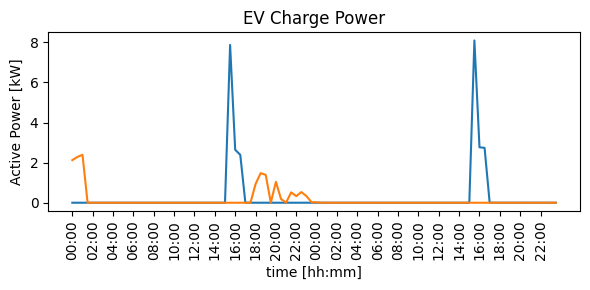

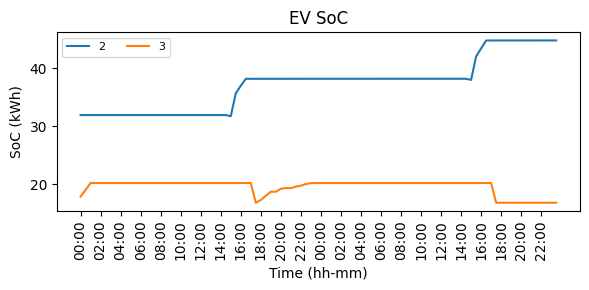

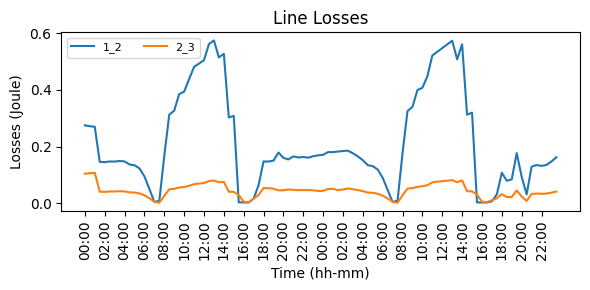

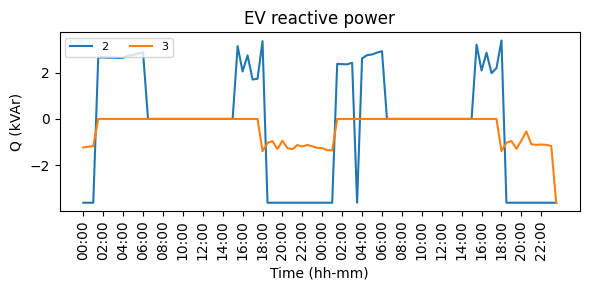

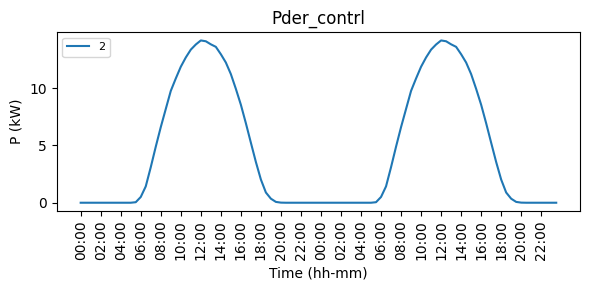

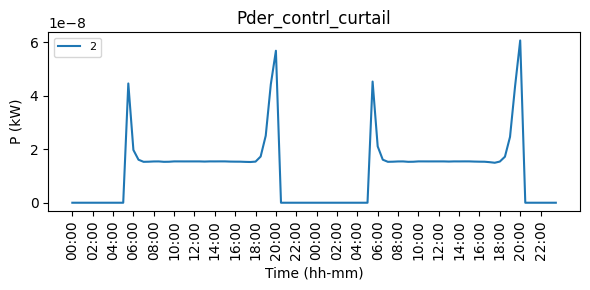

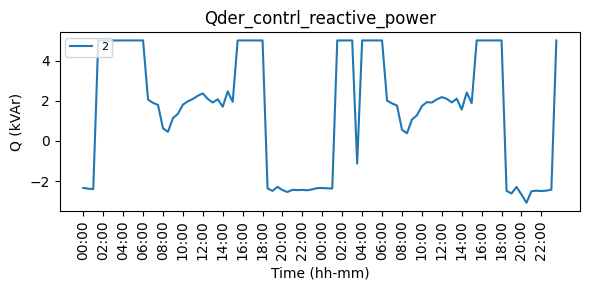

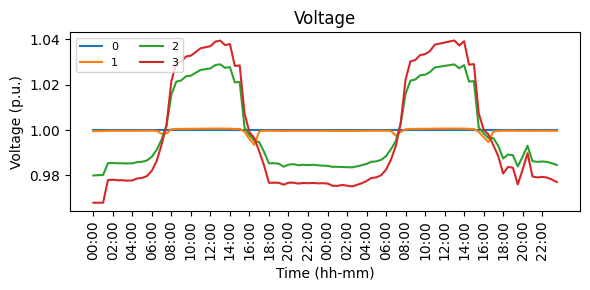

In [37]:
manager.plot_fun.result_df_plot(manager.results.pEVch*manager.anc_Vars.S_Base*1000,"EV Charge Power", "time [hh:mm]" ,"Active Power [kW]")
manager.plot_fun.result_df_plot(manager.results.EVsoc*manager.anc_Vars.S_Base*1000,"EV SoC", "Time (hh-mm)" ,"SoC (kWh)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.Line_losses*manager.anc_Vars.I_base*1000,"Line Losses", "Time (hh-mm)" ,"Losses (Joule)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qEV*manager.anc_Vars.S_Base*1000,"EV reactive power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.pder_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.pder_curtail_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl_curtail", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qder_contr*manager.anc_Vars.S_Base*1000,"Qder_contrl_reactive_power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")
manager.plot_fun.result_df_plot(np.sqrt(manager.results.v),"Voltage", "Time (hh-mm)" ,"Voltage (p.u.)", label="Yes")


In [38]:
from pyomo.environ import value

for idx in manager.model.current_lines_equal_pf:
    c = manager.model.current_lines_equal_pf[idx]
    lhs = value(c.body)
    rhs = value(c.upper) if c.has_ub() else None 
    print(f"LHS = {lhs:.8e}    RHS = {rhs:.8e}    Violation = {abs(lhs - rhs):.2e}")

for idx in manager.model.current_transformers_equal_pf:
    print(idx)
    c = manager.model.current_transformers_equal_pf[idx]
    lhs = value(c.body)
    rhs = value(c.upper) if c.has_ub() else None 
    print(f"LHS = {lhs:.8e}    RHS = {rhs:.8e}    Violation = {abs(lhs - rhs):.2e}")

LHS = -1.61821253e-08    RHS = 0.00000000e+00    Violation = 1.62e-08
LHS = -1.68972734e-08    RHS = 0.00000000e+00    Violation = 1.69e-08
LHS = -1.74540557e-08    RHS = 0.00000000e+00    Violation = 1.75e-08
LHS = -5.33002350e-08    RHS = 0.00000000e+00    Violation = 5.33e-08
LHS = -5.52382722e-08    RHS = 0.00000000e+00    Violation = 5.52e-08
LHS = -2.58892789e-08    RHS = 0.00000000e+00    Violation = 2.59e-08
LHS = -1.51804496e-08    RHS = 0.00000000e+00    Violation = 1.52e-08
LHS = -2.83757506e-08    RHS = 0.00000000e+00    Violation = 2.84e-08
LHS = -2.18229691e-08    RHS = 0.00000000e+00    Violation = 2.18e-08
LHS = -1.84910769e-08    RHS = 0.00000000e+00    Violation = 1.85e-08
LHS = -1.92441634e-08    RHS = 0.00000000e+00    Violation = 1.92e-08
LHS = -2.61150391e-08    RHS = 0.00000000e+00    Violation = 2.61e-08
LHS = -2.97752822e-08    RHS = 0.00000000e+00    Violation = 2.98e-08
LHS = -4.90829399e-08    RHS = 0.00000000e+00    Violation = 4.91e-08
LHS = -3.21150690e-0